# Нейросетевая классификация текстов

![https://freepik.com](https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/NLP_-_isometric.svg/640px-NLP_-_isometric.svg.png)

В этом проекте нам предстоит решить задачу классификации текстов. Мы будем использовать датасет [`ag_news`](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: *World, Sports, Business, Sci/Tech.*

Классификацию мы будем производить с помощью рекуррентных нейросетей. Мы попробуем применить различные архитектуры (`RNN`, `LSTM`, `GRU`), а также подберём гипер-параметры, чтобы повысить качество моделей. Сравнивать модели между собой будем по метрике `accuracy`.

In [1]:
from collections import Counter
import string

import numpy as np
import pandas as pd

import lightning as L

from sklearn.model_selection import train_test_split

from torchmetrics.classification import MulticlassAccuracy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm
from datasets import load_dataset

import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

import plotly.express as px

import fasttext

In [2]:
L.seed_everything(42)

Global seed set to 42


42

In [3]:
torch.set_float32_matmul_precision('high')

Загрузим пакет `punkt`, он нам понадобится для токенизации.

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Подготовка данных

Загрузим данные. Для этого воспользуемся библиотекой `datasets` проекта [`huggingface`](huggingface.co/).

In [5]:
dataset = load_dataset('ag_news')

Found cached dataset ag_news (/home/dev/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Данные загружены, и уже разбиты на обучающую и тестовую выборки. В обучающей выборке 120000 текстов, в тестовой — 7600. Посмотрим на баланс классов в обучающей выборке.

In [7]:
unique, counts = np.unique(np.array(dataset['train']['label']), return_counts=True)

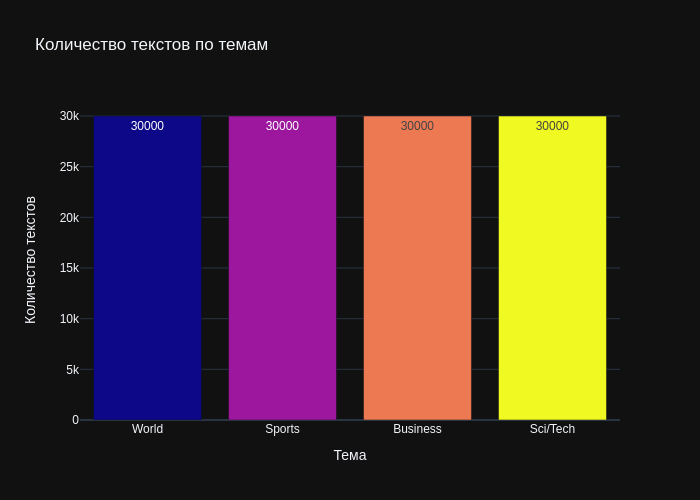

In [8]:
fig = px.bar(np.vstack([unique, counts]).T, template='plotly_dark', color=0,
             title='Количество текстов по темам',
            labels={'value': 'Количество текстов',
                   'index': 'Тема'}, text=counts)
fig.update(layout_coloraxis_showscale=False)
fig.update_layout(showlegend=False)
fig.update_layout(xaxis = dict(tickvals = [0, 1, 2, 3],
                               ticktext = ['World', 'Sports', 'Business', 'Sci/Tech']))
fig.show('png')

Все классы сбалансированы. Это сильно облегчит нашу задачу.

Теперь данные надо обработать. Отберём наиболее часто встречающиеся слова.

In [9]:
words = Counter()

for sentence in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    sentence = sentence.lower().translate(str.maketrans('', '', string.punctuation))

    for word in word_tokenize(sentence):
        words[word] += 1

100%|█████████████████████████████████| 120000/120000 [00:13<00:00, 8914.51it/s]


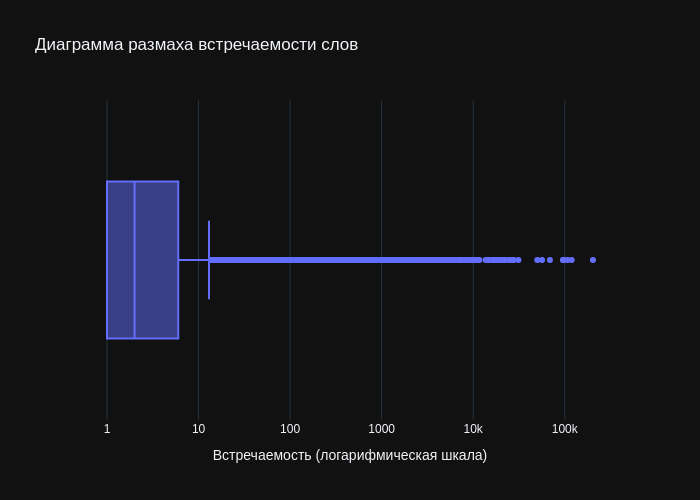

In [10]:
fig = px.box(words.values(), template='plotly_dark', log_x=True, orientation='h', 
             title='Диаграмма размаха встречаемости слов', labels={'value': 'Встречаемость (логарифмическая шкала)'})
fig.update_yaxes(visible=False)
fig.show('png')

Видно, что большое количество слов встречается в выборке всего несколько раз. Чтобы размер нашего словаря не был слишком большим, ограничимся словами, которые встретились хотя бы 25 раз. Также добавим в словарь специальные токены `<unk>, <bos>, <eos>, <pad>`, которыми мы будем обозначать неизвестные слова, начало и конец предложения, а также паддинг.

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
threshold = 25

for word, counts in words.items():
    if counts > threshold:
        vocab.add(word)

print(f'Размер словаря: {len(vocab)}')

Размер словаря: 11842


Создадим словари для быстрого поиска индекса по слову и слова по индексу, они понадобятся нам при обучении сети.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Отлично. Теперь мы готовы создать модуль данных.

In [13]:
class WordDataset:
    def __init__(self, sentences, word2ind: dict):
        self.data = sentences
        self.word2ind = word2ind
        self.unk_id = self.word2ind['<unk>']
        self.bos_id = self.word2ind['<bos>']
        self.eos_id = self.word2ind['<eos>']
        self.pad_id = self.word2ind['<pad>']

    def __getitem__(self, idx: int):
        processed_text = self.data['text'][idx].lower().translate(str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [self.word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)] 
        tokenized_sentence += [self.eos_id]

        return {'text': tokenized_sentence, 
                'label': self.data['label'][idx]}

    def __len__(self) -> int:
        return len(self.data['label'])

In [14]:
def collate_fn_with_padding(input_batch, pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch)
    labels = torch.LongTensor([x['label'] for x in input_batch])

    return {'input_ids': sequences,
            'label': labels}

In [15]:
BATCH_SIZE = 128

In [16]:
class NewsDataModule(L.LightningDataModule):
    def __init__(self, data, word2ind: dict, batch_size: int = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.data_train = data['train'].to_dict()
        self.data_val, self.data_test = train_test_split(data['test'], 
                                                         test_size=0.5, 
                                                         stratify=data['test']['label'], 
                                                         random_state=42)
        self.word2ind = word2ind

    def setup(self, stage: str):
        self.train_dataset = WordDataset(self.data_train, word2ind=self.word2ind)
        self.val_dataset = WordDataset(self.data_val, word2ind=self.word2ind)
        self.test_dataset = WordDataset(self.data_test, word2ind=self.word2ind)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=True, 
                          num_workers=12, 
                          pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False, 
                          num_workers=12, 
                          pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size,
                          collate_fn=collate_fn_with_padding,
                          shuffle=False, 
                          num_workers=12, 
                          pin_memory=True)


In [17]:
data_module = NewsDataModule(data=dataset, word2ind=word2ind, batch_size=BATCH_SIZE)

Модуль данных готов, можно приступать к созданию моделей.

## Построение и обучение моделей

Чтобы учесть склонность рекуррентных моделей в взрыву градиентов, будем применять методику gradient clipping.

### Базовая модель

Опишем базовый класс модели, с которым будем производить эксперименты. Мы хотим применить разные архитектуры рекуррентных сетей, а также попробовать модели с различными гипер-параметрами.

In [18]:
class Classifier(L.LightningModule):
    def __init__(self, 
                 arch: str, 
                 hidden_dim: int,
                 vocab_size: int,
                 learning_rate: float = 3e-05,
                 num_classes: int = 4,
                 num_layers: int = 1,
                 bidirectional: bool = False,
                 dropout_rate: float = 0,
                 aggregation_type: str = 'max',
                embedding_vectors=None):
        
        super().__init__()
        self.learning_rate = learning_rate
        self.aggregation_type = aggregation_type
        
        self.loss = nn.CrossEntropyLoss()
        self.metric = MulticlassAccuracy(num_classes=num_classes)
        
        self.losses = {'train': [],
                       'valid': [],
                       'test': []}
        self.metrics = {'train': [],
                        'valid': [],
                        'test': []}
        
        self.train_step_outputs = []
        self.valid_step_outputs = []
        self.test_step_outputs = []
        
        if embedding_vectors is None:
            input_dim = hidden_dim
            self.embedding = nn.Embedding(vocab_size, input_dim)
        else:
            input_dim = embedding_vectors.shape[1]
            self.embedding = nn.Embedding(vocab_size, 
                                          input_dim).from_pretrained(embedding_vectors, 
                                                                      freeze=False)

        if arch == 'LSTM':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                               batch_first=True, bidirectional=bidirectional, 
                               dropout=dropout_rate)
        elif arch == 'GRU':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional, 
                              dropout=dropout_rate)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=bidirectional, 
                              dropout=dropout_rate)
        if bidirectional:
            self.linear = nn.Linear(2 * hidden_dim, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
        
    def forward(self, input):
        embeddings = self.embedding(input)
        output, _ = self.rnn(embeddings)
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        else:
            output = output.mean(dim=1)
        
        output = self.dropout(self.linear(output))
        prediction = self.projection(self.non_lin(output))
        
        return prediction

    def _shared_step(self, input, stage):
        X, y = input['input_ids'], input['label']
        output = self.forward(X)

        loss = self.loss(output, y)
        accuracy = self.metric(output, y)
        
        results = {'loss': loss, 'metric': accuracy}
        
        getattr(self, f'{stage}_step_outputs').append(results)

        return results

    def _shared_epoch_end(self, stage):
        outputs = getattr(self, f'{stage}_step_outputs')
        loss = torch.tensor([x['loss'].item() for x in outputs]).mean()
        metrics = torch.vstack([x['metric'] for x in outputs]).mean()
        
        getattr(self, f'{stage}_step_outputs').clear()
        
        self.losses[stage].append(loss.item())
        self.metrics[stage].append(metrics.item())

        metrics = {f'{stage}_loss': loss,
                  f'{stage}_metric': metrics}

        self.log_dict(metrics, prog_bar=True)
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, 'valid')
    
    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, 'test')

    def on_train_epoch_end(self):
        self._shared_epoch_end('train')

    def on_validation_epoch_end(self):
        self._shared_epoch_end('valid')
        
    def on_test_epoch_end(self):
        self._shared_epoch_end('test')

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = {
            'scheduler': ReduceLROnPlateau(
                optimizer,
                patience=5), 
                'interval': 'epoch',
                'monitor': 'valid_loss'}
        
        return [optimizer], [scheduler]

Напишем функцию для визуализации результатов обучения.

In [19]:
def show_plots(model):
    losses = pd.DataFrame({'обучение': model.losses['train'],
                           'валидация': model.losses['valid'][1:]})
    metrics = pd.DataFrame({'обучение': model.metrics['train'],
                            'валидация': model.metrics['valid'][1:]})
    fig = px.line(losses, template='plotly_dark', 
              title=f'Изменение значений функции потерь по эпохам',
              labels={'index': 'Эпоха', 
                      'value': 'Значение функции потерь', 
                      'variable': 'Этап:'})
    fig.show('png')
    fig = px.line(metrics, template='plotly_dark', 
              title='Изменение значений метрики accuracy по эпохам',
              labels={'index': 'Эпоха', 
                      'value': 'Значение метрики', 
                      'variable': 'Этап:'})
    fig.show('png')
    print(f"Значение метрики на последней эпохе (валидация): {metrics['валидация'].iloc[-1]}")

### Простая `RNN`, различные типы аггрегации

Обучим простую однослойную `RNN` и посмотрим, как тип аггрегации сказывается на качестве модели. 

In [20]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'RNN'
aggregation_type = 'max'
learning_rate = 3e-5

In [21]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [22]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | RNN                | 33.0 K
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.263     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


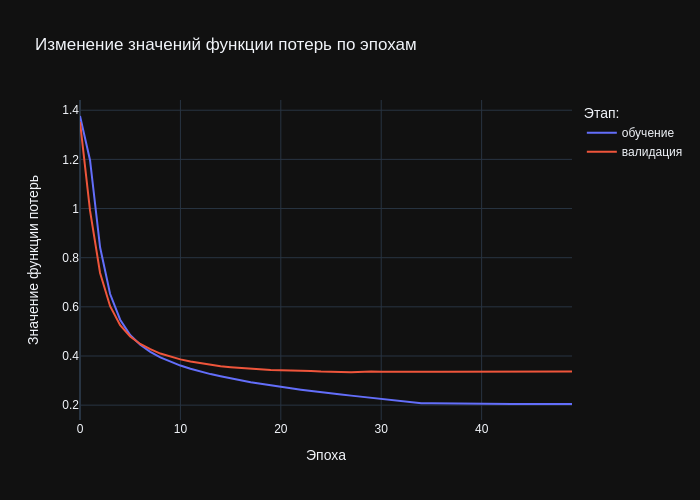

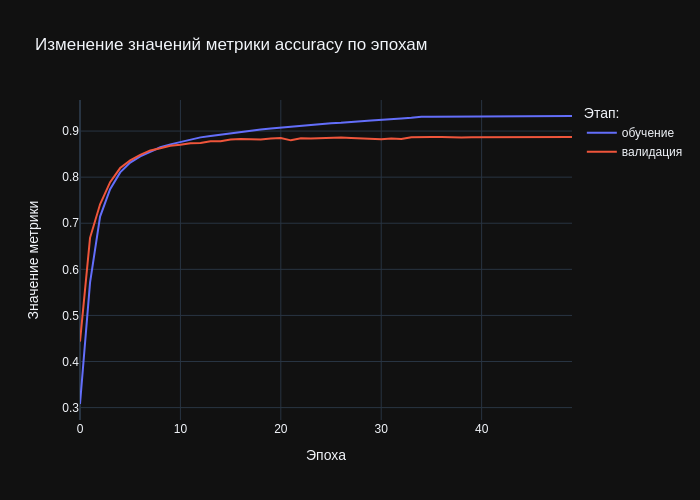

Значение метрики на последней эпохе (валидация): 0.8868885636329651


In [24]:
show_plots(model)

Поменяем тип аггрегации.

In [25]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'RNN'
aggregation_type = 'mean'
learning_rate = 3e-5

In [26]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [27]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | RNN                | 33.0 K
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.263     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


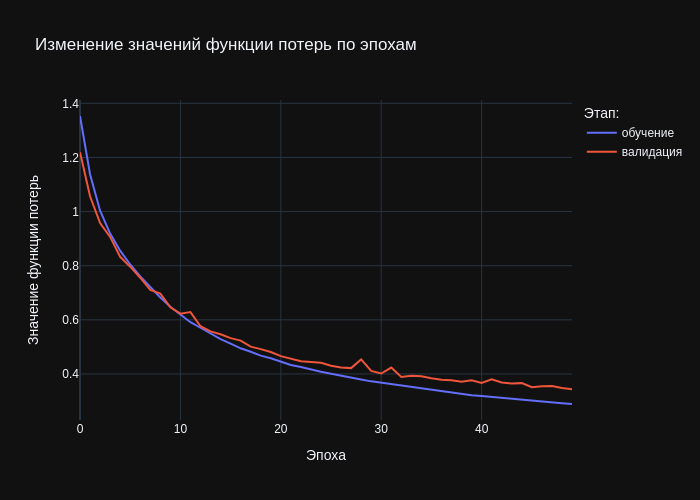

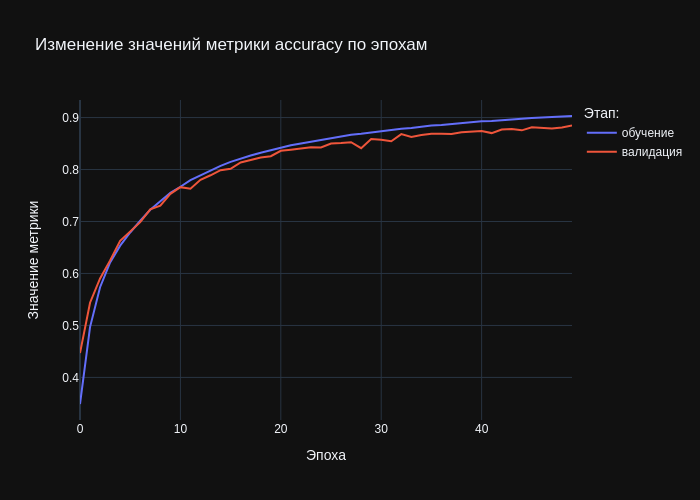

Значение метрики на последней эпохе (валидация): 0.8846701383590698


In [29]:
show_plots(model)

При различных типах аггрегации занчения метрики на последних эпохах получаются близкими друг к другу, при этом для метода `max` значения функции потерь и метрики на валидации довольно быстро выходят на плато и менее склонны к колебаниям. В дальнейших экспериментах будем использовать аггрегацию `max`.

### `LSTM` и `GRU`

Попробуем применить архитектуры `LSTM` и `GRU`. Эти архитектуры возникли как дальнейшее развитие идеи рекуррентной нейросети и менее склонны к забывчивости.

In [35]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'LSTM'
aggregation_type = 'max'
learning_rate = 2e-5

In [36]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [37]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | LSTM               | 132 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.660     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


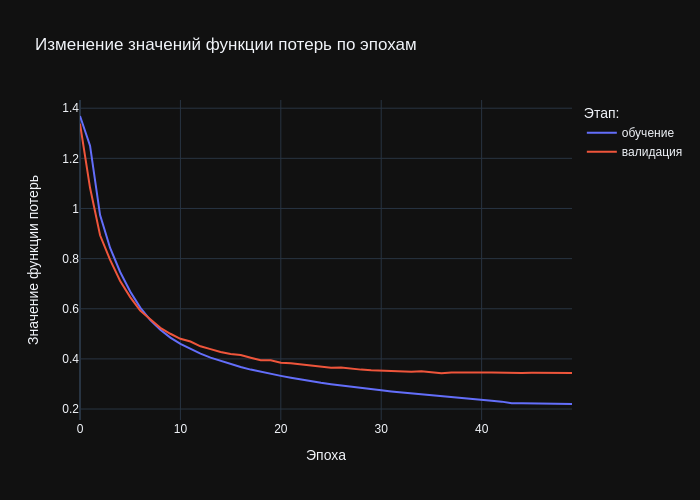

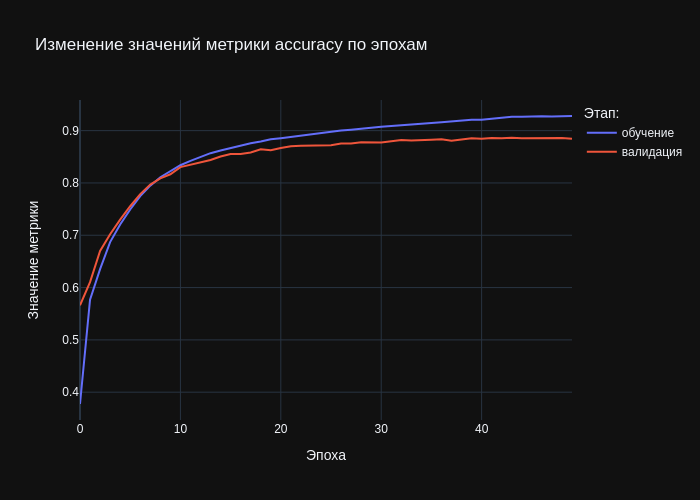

Значение метрики на последней эпохе (валидация): 0.884346067905426


In [39]:
show_plots(model)

Теперь применим архитектуру `GRU`.

In [40]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 1
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 2e-5

In [41]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [42]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 99.1 K
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.528     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


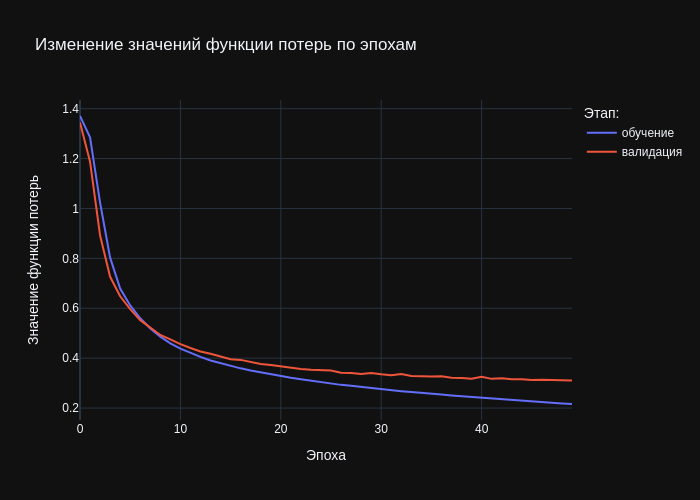

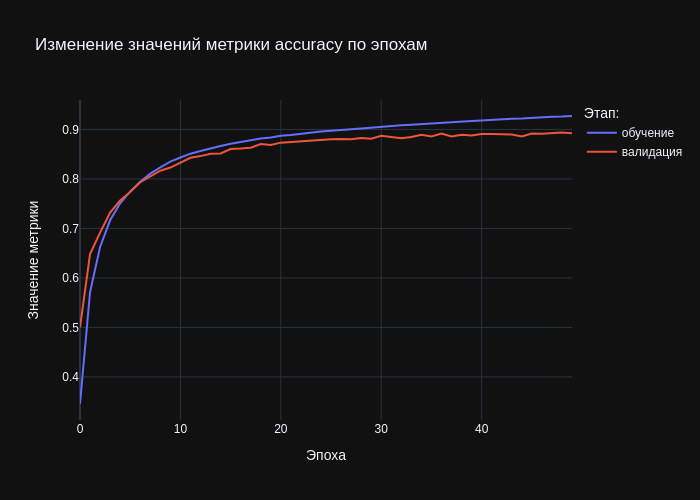

Значение метрики на последней эпохе (валидация): 0.8922706842422485


In [44]:
show_plots(model)

Применение `GRU` позволило немного улучшить метрику. Будем использовать её и в дальнейших экспериментах.

### Многослойная сеть

Попробуем увеличить количество слоёв в модели.

In [45]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 2
bidirectional = False
arch = 'GRU'
aggregation_type = 'mean'
learning_rate = 2e-5

In [46]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [47]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 198 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.924     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


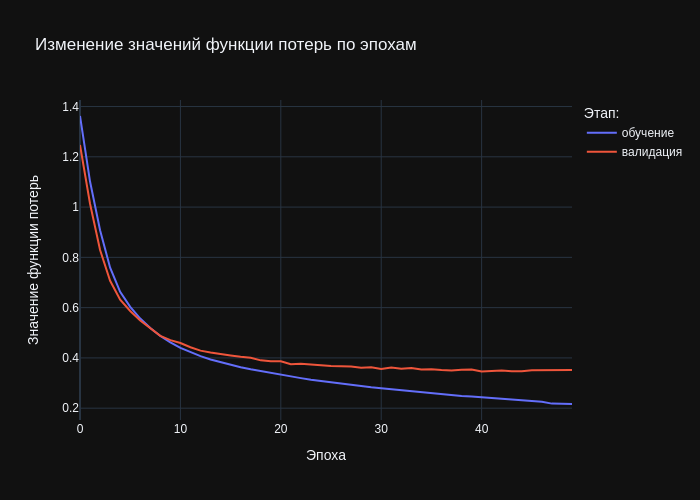

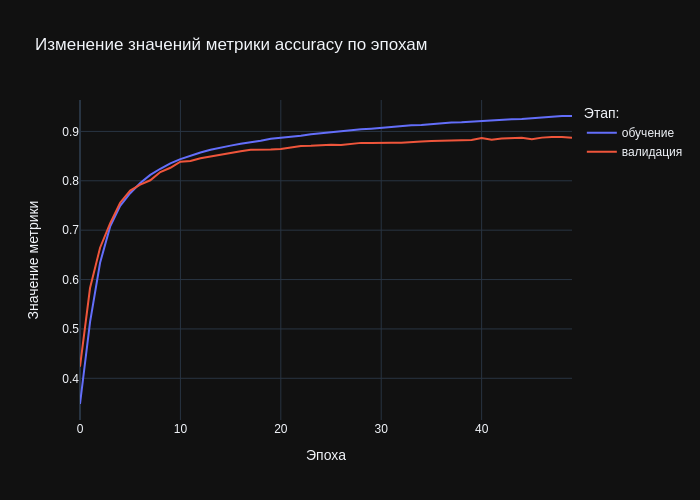

Значение метрики на последней эпохе (валидация): 0.88715660572052


In [49]:
show_plots(model)

Качество немного упало. Попробуем добавить ещё слой.

In [50]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 3
bidirectional = False
arch = 'GRU'
aggregation_type = 'mean'
learning_rate = 2e-5

In [51]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [52]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [53]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 297 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.320     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


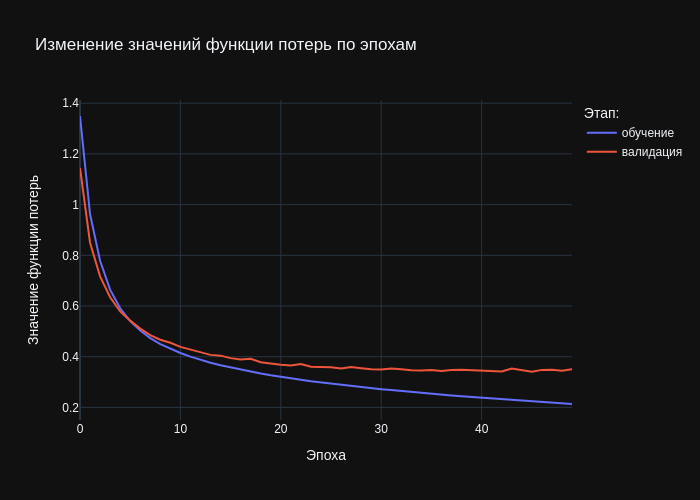

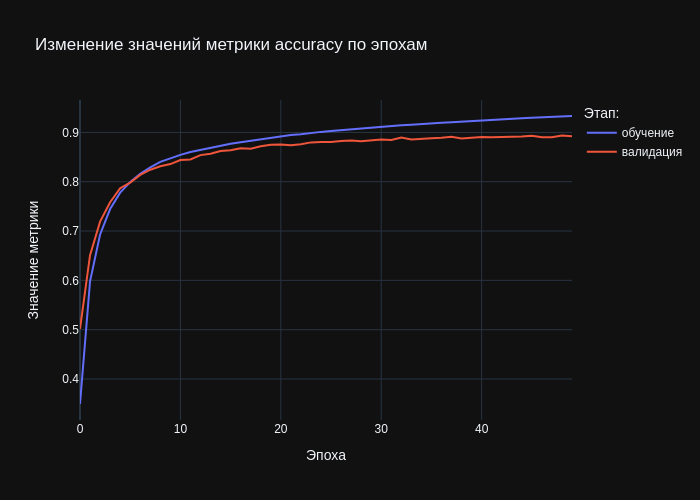

Значение метрики на последней эпохе (валидация): 0.8921407461166382


In [54]:
show_plots(model)

In [55]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0
num_layers = 4
bidirectional = False
arch = 'GRU'
aggregation_type = 'mean'
learning_rate = 2e-5

In [56]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [57]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 396 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.716     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


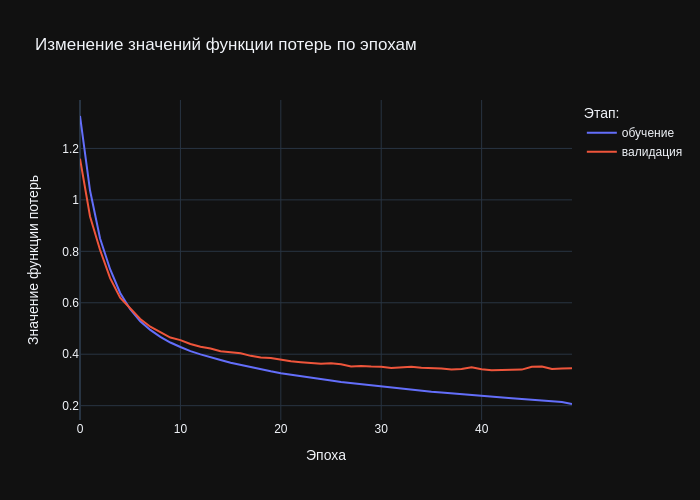

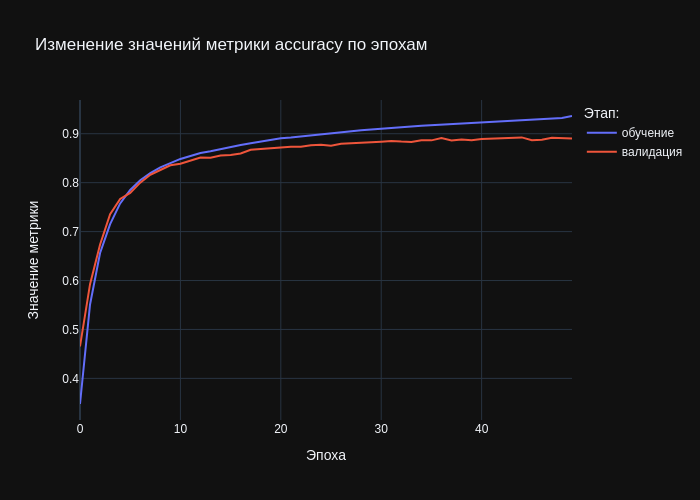

Значение метрики на последней эпохе (валидация): 0.8903980851173401


In [59]:
show_plots(model)

Добавление дополнительных слоёв не позволило нам улучшить метрику.

### Применение dropout в рекуррентной сети

Попробуем добавлять dropout непосредственно в рекуррентную сеть.

In [60]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0.1
num_layers = 3
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 2e-5

In [61]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [62]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [63]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 297 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.320     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


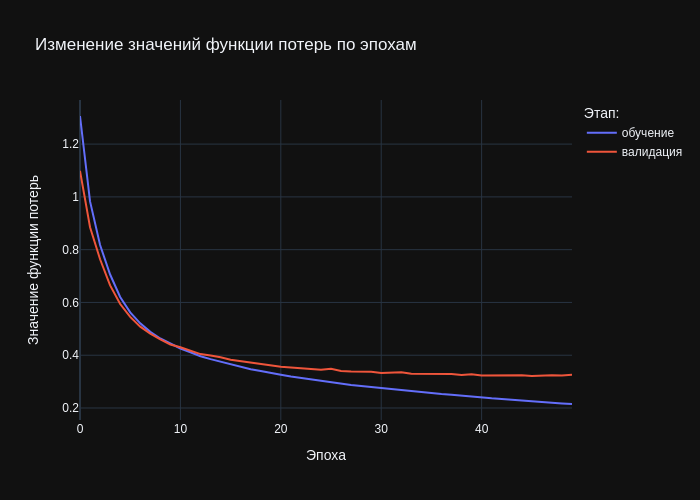

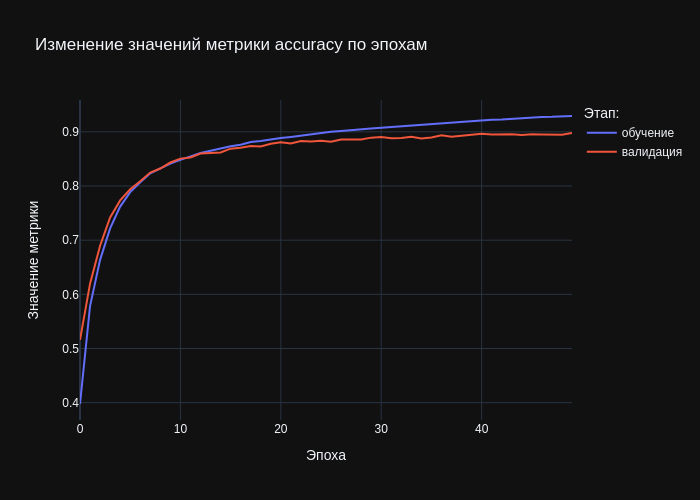

Значение метрики на последней эпохе (валидация): 0.8981064558029175


In [64]:
show_plots(model)

In [65]:
num_epoch = 50
hidden_dim = 128
dropout_rate = 0.3
num_layers = 3
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 2e-5

In [66]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [67]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 1.5 M 
3 | rnn        | GRU                | 297 K 
4 | linear     | Linear             | 16.5 K
5 | projection | Linear             | 516   
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.320     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


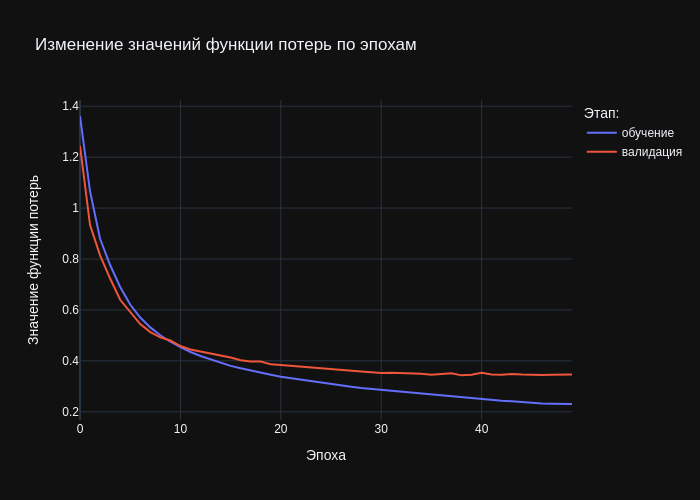

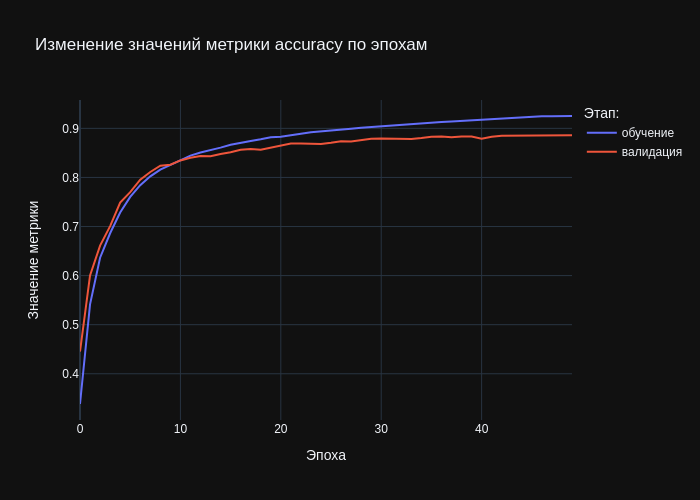

Значение метрики на последней эпохе (валидация): 0.8860170245170593


In [69]:
show_plots(model)

Наилучшего результата удалось достичь при применении многослойной модели с dropout 0.1.

### Многослойная сеть с dropout и увеличенным скрытым представлением

Увеличим размер скрытого представления и посмотрим на качество.

In [97]:
num_epoch = 50
hidden_dim = 256
dropout_rate = 0.1
num_layers = 3
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 1e-5

In [98]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [99]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [100]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 3.0 M 
3 | rnn        | GRU                | 1.2 M 
4 | linear     | Linear             | 65.8 K
5 | projection | Linear             | 1.0 K 
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.131    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


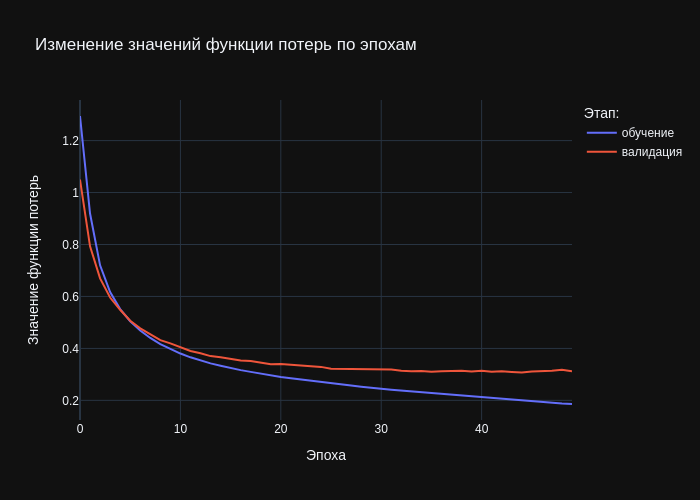

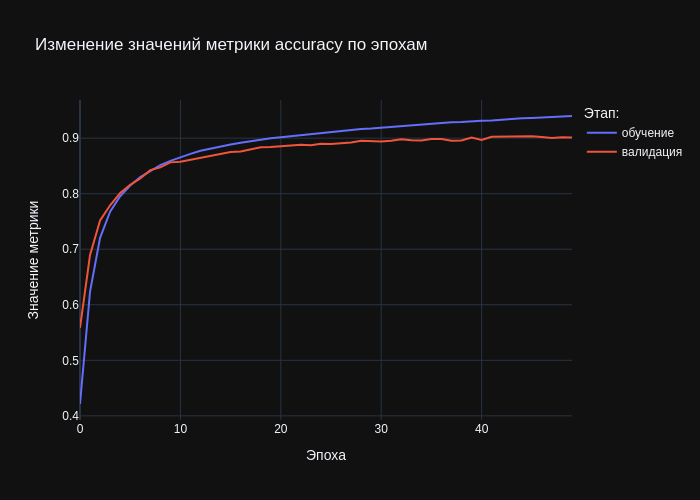

Значение метрики на последней эпохе (валидация): 0.9011927247047424


In [101]:
show_plots(model)

In [107]:
num_epoch = 50
hidden_dim = 512
dropout_rate = 0.1
num_layers = 3
bidirectional = False
arch = 'GRU'
aggregation_type = 'max'
learning_rate = .9e-5

In [108]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [109]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [110]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 6.1 M 
3 | rnn        | GRU                | 4.7 M 
4 | linear     | Linear             | 262 K 
5 | projection | Linear             | 2.1 K 
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
11.1 M    Trainable params
0         Non-trainable params
11.1 M    Total params
44.222    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


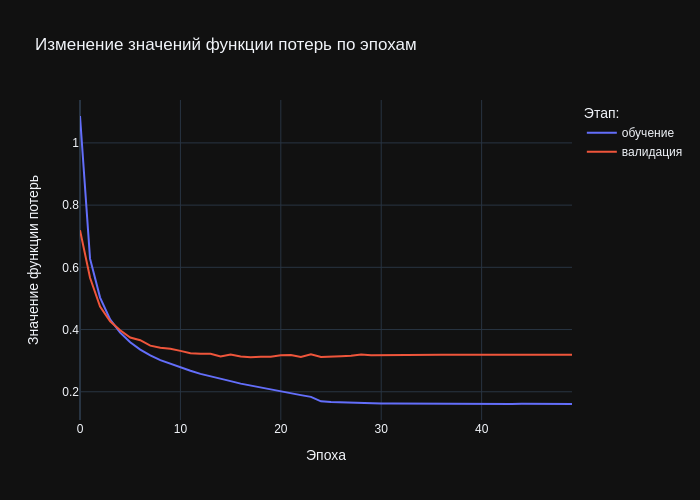

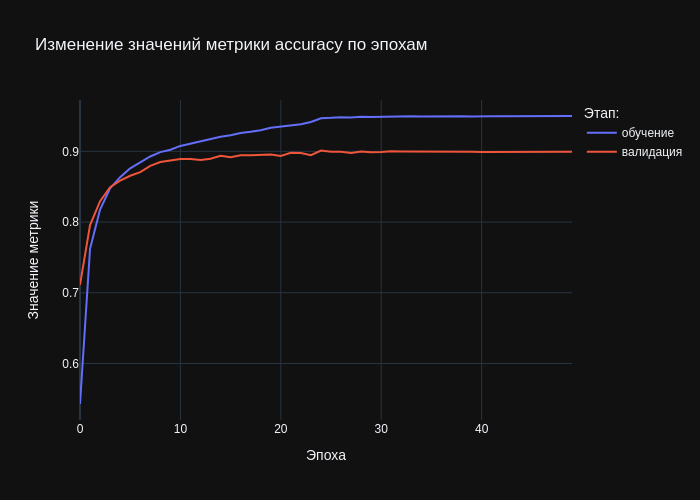

Значение метрики на последней эпохе (валидация): 0.8993719816207886


In [111]:
show_plots(model)

Увеличение скрытого представления позволило нам повысить целевую метрику. Хорошо, перейдём к дальнейшим экспериментам.

### Многослойная двунаправленная сеть с увеличенным скрытым представлением

Попробуем использовать двунаправленную сеть, которая просматривает поступающие значения из начала в конец и из конца в начало.

In [112]:
num_epoch = 50
hidden_dim = 256
dropout_rate = 0.1
num_layers = 3
bidirectional = True
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 1e-5

In [113]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate)

In [114]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [115]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 3.0 M 
3 | rnn        | GRU                | 3.2 M 
4 | linear     | Linear             | 131 K 
5 | projection | Linear             | 1.0 K 
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.275    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


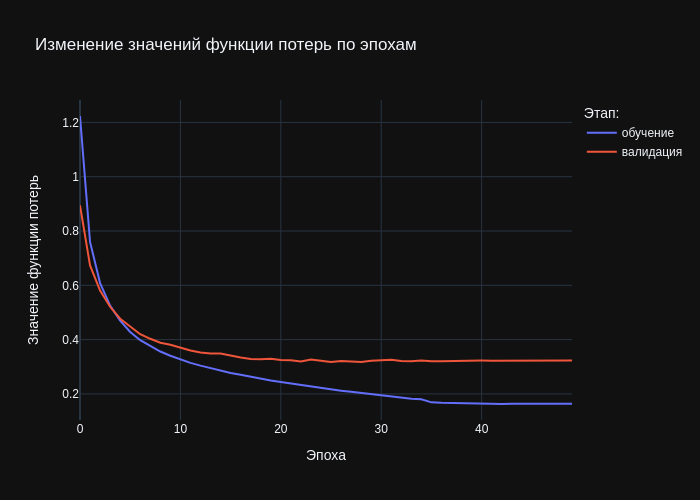

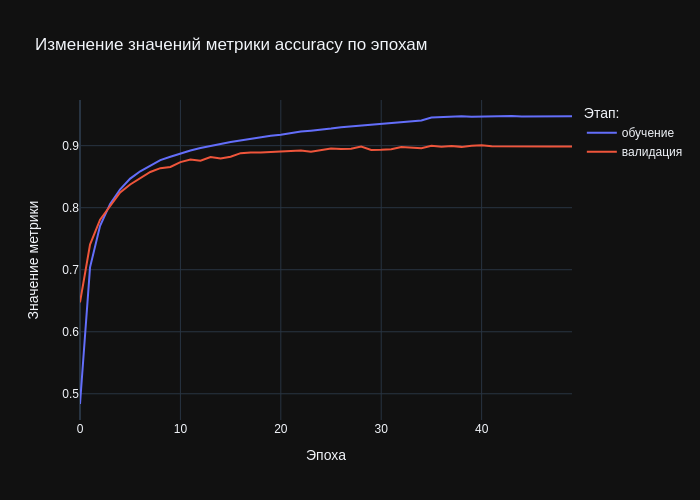

Значение метрики на последней эпохе (валидация): 0.8986803889274597


In [116]:
show_plots(model)

Применение двунаправленной сети не позволило нам улучшить метрику, перейдём к дальнейшим экспериментам.

### `FastText`

Попробуем улучшить предсказания модели за счёт предобученных эмбеддингов, полученных из модели `FastText`. Вектора `FastText` лучше описывают как отдельные слова, так и взаимосвязи между словами, так что рекуррентной сети будет проще использовать эту информацию в предсказаниях. 

In [39]:
num_epoch = 50
hidden_dim = 256
dropout_rate = 0.1
num_layers = 3
bidirectional = True
arch = 'GRU'
aggregation_type = 'max'
learning_rate = 0.7e-5

In [40]:
vectorizer = fasttext.load_model('cc.en.300.bin')

In [41]:
emb = [vectorizer.get_word_vector(word) for _, word in ind2word.items()]

In [42]:
del vectorizer

In [43]:
emb = torch.tensor(np.vstack(emb))

In [44]:
model = Classifier(arch=arch, 
                   hidden_dim=hidden_dim,
                   vocab_size=len(vocab),
                   num_layers=num_layers,
                   bidirectional=bidirectional,
                   dropout_rate=dropout_rate,
                   aggregation_type=aggregation_type,
                   learning_rate=learning_rate,
                   embedding_vectors=emb)

In [45]:
trainer = L.Trainer(max_epochs=num_epoch, 
                    accelerator='gpu', 
                    log_every_n_steps=10, 
                    gradient_clip_val=0.5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | loss       | CrossEntropyLoss   | 0     
1 | metric     | MulticlassAccuracy | 0     
2 | embedding  | Embedding          | 3.6 M 
3 | rnn        | GRU                | 3.2 M 
4 | linear     | Linear             | 131 K 
5 | projection | Linear             | 1.0 K 
6 | non_lin    | Tanh               | 0     
7 | dropout    | Dropout            | 0     
--------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.630    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


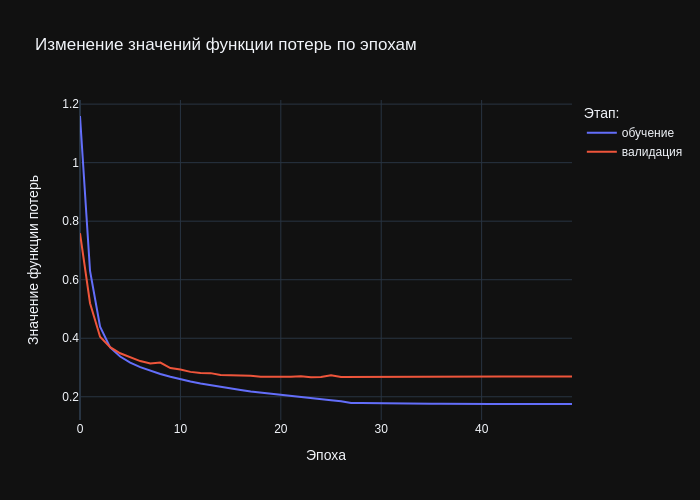

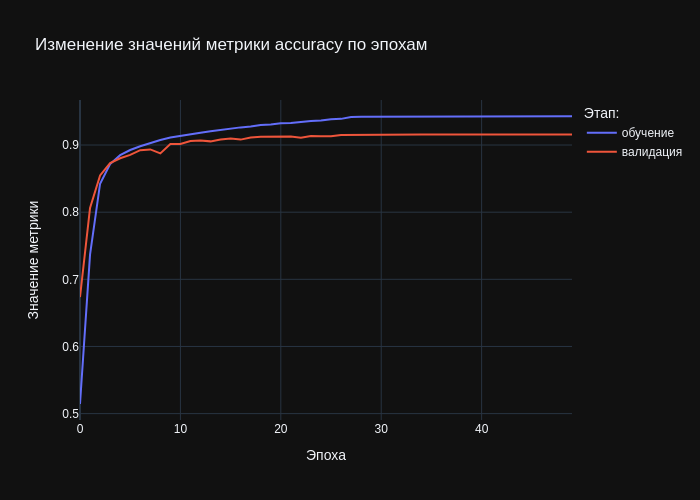

Значение метрики на последней эпохе (валидация): 0.9158250689506531


In [47]:
show_plots(model)

Похоже, что наша модель немного переобучилась, но благодаря применению предобученных векторов слов нам удалось существенно повысить метрику на валидации.

## Получение предсказаний на тестовых данных

Возьмём модель, лучше всего показавшую себя на валидационных данных, и посмотрим на значение метрики на тестовых данных.

In [48]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.277340829372406     │
│        test_metric        │    0.9118825793266296     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.277340829372406, 'test_metric': 0.9118825793266296}]

Значание метрики получилось нижне, чем на валидационных данных, но не значительно. Хороший результат!

## Вывод по проекту

В ходе данной работы мы обучили несколько нейростевых моделей, относящих англоязычные тексты новостей к одному из четырёх классов: `World, Sports, Business, Sci/Tech`. Для этого мы использовали набор данных `ag-news`. В данном наборе примеры всех классов сбалансированы (в обучающей выборке приведено по 30 тысяч примеров новостей каждого класса).

Все тексты из набора мы разделили на отдельные слова-токены с помощью библиотеки `nltk`, привели к нижнему регистру и удалили символы пунктуации. Чтобы уменьшить размер словаря мы исключили из него все слова, встречающиеся в тексте менее 25 раз. В результате в словарь нашей модели попало 11842 слова.

Нашей целью было получение модели, классифицирующей тексты с дастаточно высоким значением метрики `accuracy`. Для этого мы провели несколько экспериментов с различными типами рекурентных архитектур (`RNN`, `LSTM`, `GRU`), различными значениями гипер-параметров (количество слоёв нейросети, размер скрытого представления, использование двунаправленных нейросетей, значение `dropout rate`) и различными видами обработки исходных данных (слой `embedding` без предобучения и на основе векторов `FastText`).

Для сравнения эффективности моделей для каждого эксперимента мы строили графики значений функции потерь и метрики `accuracy` на всём периоде обучения. Во всех экспериментах модели обучались по 50 эпох. Если в ходе эксперимента удавалось достичь улучшения целевой метрики, значения гипер-параметров переносились в следующий эксперимент.

Сведём данные по значениям метрики на валидационных данных на последних эпохах в таблицу.

| Модель | `Accuracy` на валидации |
| ------ | ----------------------- |
| `RNN`, аггрегация max | 0.8869 |
| `RNN`, аггрегация mean | 0.8847 |
| `LSTM` | 0.8843 |
| `GRU` | 0.8923 |
| `GRU`, 2 слоя | 0.8872 |
| `GRU`, 3 слоя | 0.8921 |
| `GRU`, 4 слоя | 0.8904 |
| `GRU`, 3 слоя, dropout 0.1 | 0.8981 |
| `GRU`, 3 слоя, dropout 0.3 | 0.8860 |
| `GRU`, скрытое представление 256 | 0.9012 |
| `GRU`, скрытое представление 512 | 0.8994 |
| `Bidirectional GRU` | 0.8987 |
| `GRU` с векторами `FastText` | 0.9158 |

Из таблицы видно, что наиболее заметных улучшений целевой метрики удавалось добиться при переходе на архитектуру `GRU`, увеличении скрытого представления и при использовании предобученных эмбеддингов на основе векторов FastText.

Наилучшие результаты (значение метрики на валидации 0.9158) удалось достичь для последней модели. Мы также рассчитали для неё значение метрики на тестовых данных (0.9118).

Для дальнейшего улучшения метрики можно попробовать использовать более новые нейросетевые архитектуры, например, трансформеры.